In [7]:
import torchvision
from os.path import join as j_
from PIL import Image
import pandas as pd
import numpy as np
import torch

# loading all packages here to start
from uni import get_encoder
from uni.downstream.extract_patch_features import extract_patch_features_from_dataloader
from uni.downstream.eval_patch_features.linear_probe import eval_linear_probe
from uni.downstream.eval_patch_features.fewshot import eval_knn, eval_fewshot
from uni.downstream.eval_patch_features.protonet import ProtoNet, prototype_topk_vote
from uni.downstream.eval_patch_features.metrics import get_eval_metrics, print_metrics
from uni.downstream.utils import concat_images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = warnings, 2 = errors, 3 = fatal errors onlyimport os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [ ]:
from torchvision import transforms
import timm
from huggingface_hub import login, hf_hub_download

local_dir = "../assets/ckpts/vit_large_patch16_224.dinov2.uni_mass100k/"
os.makedirs(local_dir, exist_ok=True)  
hf_hub_download("MahmoodLab/UNI", filename="pytorch_model.bin", local_dir=local_dir, force_download=True)

model = timm.create_model(
    "vit_large_patch16_224", img_size=224, patch_size=16, init_values=1e-5, num_classes=0, dynamic_img_size=True
)
model.load_state_dict(torch.load(os.path.join(local_dir, "pytorch_model.bin"), map_location="cpu", weights_only=False), strict=True)
model.eval()
model.to(device)
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)
transform

Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)

In [9]:
from uni import get_encoder
model, transform = get_encoder(enc_name='uni', device=device)

### Site-tracking using Unique-tissue tiles only

In [ ]:
from uni.downstream.extract_patch_features import extract_patch_features_from_dataloader

# get path to BCSS data
dataroot = '../data/_bcss224/'

# create some image folder datasets for train/test and their data laoders
train_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'train_uniq_site'), transform=transform)
test_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'test_uniq_site'), transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

# extract patch features from the train and test datasets (returns dictionary of embeddings and labels)
train_features = extract_patch_features_from_dataloader(model, train_dataloader)
test_features = extract_patch_features_from_dataloader(model, test_dataloader)

# convert these to torch
train_feats = torch.Tensor(train_features['embeddings'])
train_labels = torch.Tensor(train_features['labels']).type(torch.long)
test_feats = torch.Tensor(test_features['embeddings'])
test_labels = torch.Tensor(test_features['labels']).type(torch.long)

100%|██████████| 172/172 [00:04<00:00, 41.46it/s]


### ROI Linear Probe Evaluation.

Linear Probe Evaluation: Train shape torch.Size([1567, 1024])
Linear Probe Evaluation: Test shape torch.Size([686, 1024])
Linear Probe Evaluation (Train Time): Best cost = 184.320
Linear Probe Evaluation (Train Time): Using only train set for evaluation. Train Shape:  torch.Size([1567, 1024])
(Before Training) Loss: 2.890
(After Training) Loss: 0.012
Linear Probe Evaluation (Test Time): Test Shape torch.Size([686, 1024])
Linear Probe Evaluation: Time taken 0.46


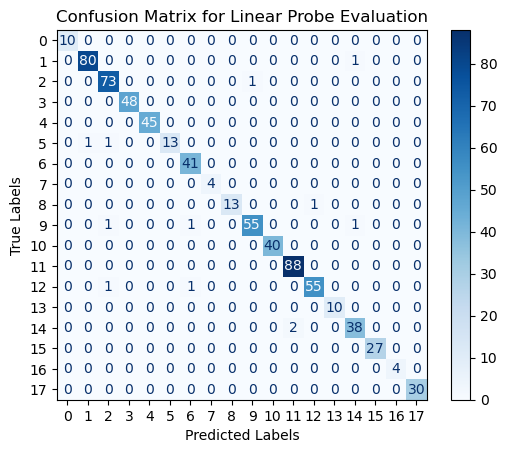

Test lin_acc: 0.983
Test lin_bacc: 0.980
Test lin_kappa: 0.985
Test lin_weighted_f1: 0.982
Test lin_auroc: 1.000


In [33]:
from uni.downstream.eval_patch_features.fewshot import eval_knn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from uni.downstream.eval_patch_features.linear_probe import eval_linear_probe

linprobe_eval_metrics, linprobe_dump = eval_linear_probe(
    train_feats = train_feats,
    train_labels = train_labels,
    valid_feats = None ,
    valid_labels = None,
    test_feats = test_feats,
    test_labels = test_labels,
    max_iter = 1000,
    verbose= True,
)

pred_labels = linprobe_dump['preds_all']
true_labels = test_labels

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix for Linear Probe Evaluation")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print_metrics(linprobe_eval_metrics)

### Site-tracking Test using Major-tissue (ALL) tiles

In [ ]:
from uni.downstream.extract_patch_features import extract_patch_features_from_dataloader

# get path to BCSS data
dataroot = '../data/_bcss224/'

# create some image folder datasets for train/test and their data laoders
train_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'train_all_site'), transform=transform)
test_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'test_all_site'), transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# extract patch features from the train and test datasets (returns dictionary of embeddings and labels)
train_features = extract_patch_features_from_dataloader(model, train_dataloader)
test_features = extract_patch_features_from_dataloader(model, test_dataloader)

# convert these to torch
train_feats = torch.Tensor(train_features['embeddings'])
train_labels = torch.Tensor(train_features['labels']).type(torch.long)
test_feats = torch.Tensor(test_features['embeddings'])
test_labels = torch.Tensor(test_features['labels']).type(torch.long)

  0%|          | 0/655 [00:00<?, ?it/s]

100%|██████████| 282/282 [00:24<00:00, 11.57it/s]


### ROI Linear Probe Evaluation.

Linear Probe Evaluation: Train shape torch.Size([10465, 1024])
Linear Probe Evaluation: Test shape torch.Size([4497, 1024])
Linear Probe Evaluation (Train Time): Best cost = 204.800
Linear Probe Evaluation (Train Time): Using only train set for evaluation. Train Shape:  torch.Size([10465, 1024])
(Before Training) Loss: 2.996
(After Training) Loss: 0.016
Linear Probe Evaluation (Test Time): Test Shape torch.Size([4497, 1024])
Linear Probe Evaluation: Time taken 0.74


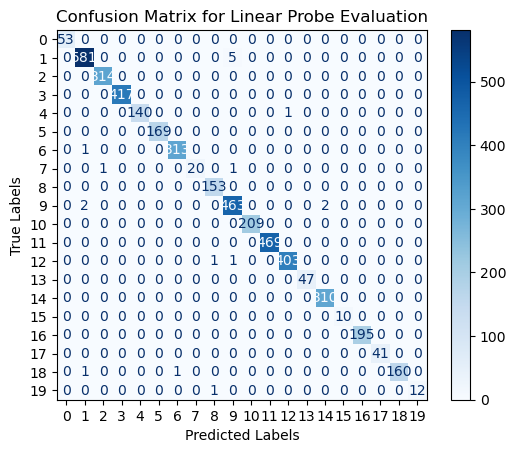

Test lin_acc: 0.996
Test lin_bacc: 0.989
Test lin_kappa: 0.995
Test lin_weighted_f1: 0.996
Test lin_auroc: 1.000


In [45]:
from uni.downstream.eval_patch_features.linear_probe import eval_linear_probe

linprobe_eval_metrics, linprobe_dump = eval_linear_probe(
    train_feats = train_feats,
    train_labels = train_labels,
    valid_feats = None ,
    valid_labels = None,
    test_feats = test_feats,
    test_labels = test_labels,
    max_iter = 1000,
    verbose= True,
)

pred_labels = linprobe_dump['preds_all']
true_labels = test_labels

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix for Linear Probe Evaluation")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print_metrics(linprobe_eval_metrics)